# Farm Planning Problem

Las tres principales insumos de la producción agricola son el terreno, la mano de obra y el agua. Sus requerimiento varían a través de los años según las distintas actividades de cultivo desarrolladas en el terreno.

La rotación de los cultivos es la práctica de plantar diferentes cultivos secuencialmente en la misma parcela. Esta rotación y su agendamiento en el mundo real requiere del apoyo de un agronomo. Para el modelo se supondrá que el agronomo ya registro que tipos de cultivos se pueden cultivar en cada periodo y cuanto tiempo el cultivo demorá en crecer. 

El uso de mano de obra varía de año a año y de acuerdo al periodo, ya que existen distintas actividades según el periodo, como pueden ser la preparación del terreno, plantación, mantenimiento y cocecha. Para cada tipo de cultivo existe distintos requerimientos de mano de obra según el periodo.

Además de los trabajadores ya disponibles se puede contratar trabajadores permanentes o temporales.

Considere que existen 10 hectareas de terreno cultivable.

Versión resumida del problema encontrado en [AIMMS Modeling Guide - Farm Planning Problem](https://download.aimms.com/aimms/download/manuals/AIMMS3OM_FarmPlanning.pdf)

In [2]:
import pandas as pd
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt

# Subíndices
*i*=cultivo

*t*=período


# Parámetros

$TO_{it}$= % de ocupación del terreno en el periodo *t* en caso de cultivarse el cultivo *i*

$HHC_{it}$= Horas Humanas requeridas para el cultivo *i* en el periodo *t* 

$HHDisp_{t}$= Horas Humanas disponibles en el periodo *t* por cada trabajador 

$ProdHa_{i}$= Toneladas producicas por cada hectarea del cultivo *i*

$PTon_{i}$= Precio de mercado por cada tonelada del cultivo *i*

*TP*= Trabajadores permanentes mínimos

*CHHTemporal*= Costo de la HH de un trabajador temporal

In [3]:
cultivo=["trigo","legumbres","cebolla","algodon","maiz","tomates"]
periodo=[1,2,3,4,5,6,7,8,9,10,11,12]

arcos=[(i,t) for i in cultivo for t in periodo]
# % de ocupación del terreno en el periodo t en caso de cultivarse el cultivo i
TO={("trigo",1):1,("trigo",2):1,("trigo",3):1,("trigo",4):1,("trigo",5):1,("trigo",6):0,("trigo",7):0,("trigo",8):0,
("trigo",9):0,("trigo",10):0,("trigo",11):0.5,("trigo",12):1,("legumbres",1):1,("legumbres",2):1,("legumbres",3):1,
("legumbres",4):1,("legumbres",5):0,("legumbres",6):0,("legumbres",7):0,("legumbres",8):0,("legumbres",9):0,("legumbres",10):0,
("legumbres",11):0.25,("legumbres",12):1,("cebolla",1):1,("cebolla",2):1,("cebolla",3):1,("cebolla",4):1,("cebolla",5):0.25,
("cebolla",6):0,("cebolla",7):0,("cebolla",8):0,("cebolla",9):0,("cebolla",10):0,("cebolla",11):0.5,("cebolla",12):1,
("algodon",1):0,("algodon",2):0,("algodon",3):0.5,("algodon",4):1,("algodon",5):1,("algodon",6):1,("algodon",7):1,
("algodon",8):1,("algodon",9):1,("algodon",10):1,("algodon",11):0.75,("algodon",12):0,("maiz",1):0,("maiz",2):0,("maiz",3):0,
("maiz",4):0, ("maiz",5):0.5,("maiz",6):1,("maiz",7):1,("maiz",8):1,("maiz",9):1,("maiz",10):0.5,("maiz",11):0,("maiz",12):0,
("tomates",1):0,("tomates",2):0,("tomates",3):0,("tomates",4):0,("tomates",5):0,("tomates",6):0,("tomates",7):0.75,("tomates",8):1,
("tomates",9):1,("tomates",10):1,("tomates",11):0.75,("tomates",12):0}

#Horas Humanas requeridas para el cultivo *i* en el periodo *t* 
HHC={("trigo",1):14,("trigo",2):4,("trigo",3):8,("trigo",4):8,("trigo",5):137,("trigo",6):0,("trigo",7):0,("trigo",8):0,
("trigo",9):0,("trigo",10):0,("trigo",11):19,("trigo",12):1,("legumbres",1):11,("legumbres",2):6,("legumbres",3):6,
("legumbres",4):128,("legumbres",5):0,("legumbres",6):0,("legumbres",7):0,("legumbres",8):0,("legumbres",9):0,("legumbres",10):0,
("legumbres",11):60,("legumbres",12):6,("cebolla",1):41,("cebolla",2):40,("cebolla",3):40,("cebolla",4):155,("cebolla",5):19,
("cebolla",6):0,("cebolla",7):0,("cebolla",8):0,("cebolla",9):0,("cebolla",10):0,("cebolla",11):89,("cebolla",12):37,
("algodon",1):0,("algodon",2):0,("algodon",3):40,("algodon",4):40,("algodon",5):72,("algodon",6):16,("algodon",7):12,
("algodon",8):16,("algodon",9):8,("algodon",10):46,("algodon",11):34,("algodon",12):0,("maiz",1):0,("maiz",2):0,("maiz",3):0,
("maiz",4):0, ("maiz",5):34,("maiz",6):40,("maiz",7):57,("maiz",8):64,("maiz",9):35,("maiz",10):9,("maiz",11):0,("maiz",12):0,
("tomates",1):0,("tomates",2):0,("tomates",3):0,("tomates",4):0,("tomates",5):0,("tomates",6):0,("tomates",7):136,("tomates",8):120,
("tomates",9):96,("tomates",10):56,("tomates",11):48,("tomates",12):0}

#Horas Humanas disponibles en el periodo *t* por cada trabajador Permanente
HHdisp={1:160,2:160,3:184,4:176,5:168,6:176,7:176,8:176,9:176,10:168,11:176,12:176}

CTP=40000
CHHTemporal=4

ProdHa={"trigo":1.5,"legumbres":1,"cebolla":6,"algodon":1.5,"maiz":1.75,"tomates":6}
PTon={"trigo":1500,"legumbres":2500,"cebolla":1250,"algodon":4000,"maiz":1200,"tomates":1300}

In [4]:
m=Model("Farming Planning")

Academic license - for non-commercial use only - expires 2021-11-29
Using license file C:\Users\pablo\gurobi.lic


# Variables de decisión

$X_i$= Número de hectareas plantadas con el cultivo i

$Y$= Número de trabajadores permanentes contratados

$Ytemp_t$= Número de hh contradas con trabajadores temporales en el período $t$

In [5]:
x=m.addVars(cultivo, name='x',vtype=GRB.INTEGER)
y=m.addVar(name='y',vtype=GRB.INTEGER)
ytemp=m.addVars(periodo,name='ytemp',vtype=GRB.INTEGER)

# Función Objetivo

$Max Z= \sum_{i}^I X_i*ProdHa_i*PTon_i -\sum_{t}^T Ytemp*CHHTemporal -Y*CTP $

In [6]:
z=quicksum(x[i]*ProdHa[i]*PTon[i] for i in cultivo)-quicksum(ytemp[t]*CHHTemporal for t in periodo)- y*CTP
m.setObjective(z,GRB.MAXIMIZE)

# Restricciones

Limite de terreno:

$\sum_{i} TO_{it}*x_i<= 10$

Requerimiento de mano de obra

$ \sum_{i}HHC_{it}*x_i<=y*HHdisp_t + ytemp   \forall t $

Número mínimo de trabajadores

$Y>=2$



R1:
$\sum_{i} TO_{it}*x_i<= 10      \forall t$

In [7]:
m.addConstrs(quicksum(x[i]*TO[i,t] for i in cultivo)<=10  for t in periodo)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>}

R2:
$ \sum_{i}HHC_{it}*x_i<=y*HHdisp_t + ytemp   \forall t $

In [8]:
m.addConstrs(quicksum(x[i]*HHC[i,t] for i in cultivo)<=y*HHdisp[t]+ytemp[t]  for t in periodo)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>}

R3:
$Y>=2$

In [9]:
m.addConstr(y>=2)

<gurobi.Constr *Awaiting Model Update*>

In [10]:
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 25 rows, 19 columns and 105 nonzeros
Model fingerprint: 0x1bc35077
Variable types: 0 continuous, 19 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
Found heuristic solution: objective -19564.00000
Presolve removed 9 rows and 0 columns
Presolve time: 0.02s
Presolved: 16 rows, 19 columns, 80 nonzeros
Variable types: 0 continuous, 19 integer (0 binary)

Root relaxation: objective 3.738400e+04, 11 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 37384.0000    0    6 -19564.000 37384.0000   291%     -    0s
H    0     0                    33136.000000 37384.0000  12.8%   

In [11]:
#Estado de la solución
if m.status==2:
    print("Función Objetivo: ",str(round(m.objVal,2)))
    for v in m.getVars():
        if v.x>0:
            print(str(v.VarName)+"="+str(round(v.x,2)))
else:
    print("Solución Infactible")

Función Objetivo:  34576.0
x[legumbres]=1.0
x[cebolla]=9.0
x[maiz]=3.0
x[tomates]=7.0
y=2.0
ytemp[1]=60.0
ytemp[2]=46.0
ytemp[4]=1171.0
ytemp[7]=771.0
ytemp[8]=680.0
ytemp[9]=425.0
ytemp[10]=83.0
ytemp[11]=845.0


## HH totales trabajadas por periodo

In [18]:
hhtot=[sum(x[i].x*HHC[i,t] for i in cultivo) for t in periodo]
hhtot

[380.0,
 366.0,
 366.0,
 1523.0,
 273.0,
 120.0,
 1123.0,
 1032.0,
 777.0,
 419.0,
 1197.0,
 339.0]

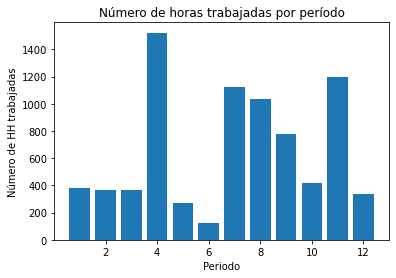

In [19]:
plt.bar(periodo, hhtot)
 
## Legenda en el eje y
plt.ylabel('Número de HH trabajadas')
 
## Legenda en el eje x
plt.xlabel('Periodo')
 
## Título de Gráfica
plt.title('Número de horas trabajadas por período')
 
## Mostramos Gráfica
plt.show()

## Uso del terreno

In [20]:
UsoTerreno=[sum(x[i].x*TO[i,t] for i in cultivo) for t in periodo]
UsoTerreno

[10.0, 10.0, 10.0, 10.0, 3.75, 3.0, 8.25, 10.0, 10.0, 8.5, 10.0, 10.0]

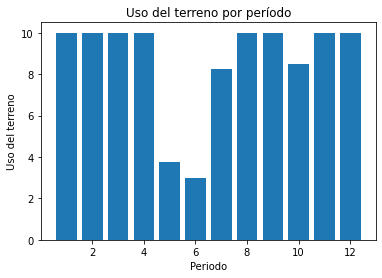

In [21]:
plt.bar(periodo, UsoTerreno)
 
## Legenda en el eje y
plt.ylabel('Uso del terreno')
 
## Legenda en el eje x
plt.xlabel('Periodo')
 
## Título de Gráfica
plt.title('Uso del terreno por período')
 
## Mostramos Gráfica
plt.show()

## ¿Cuanto Plantar de cada cultivo?

In [26]:
for i in cultivo:
    if x[i].x>0:
        print(" Se deben plantar",str(int(x[i].x)),"hectareas de",i)

 Se deben plantar 1 hectareas de legumbres
 Se deben plantar 9 hectareas de cebolla
 Se deben plantar 3 hectareas de maiz
 Se deben plantar 7 hectareas de tomates


# Horas extra contratadas

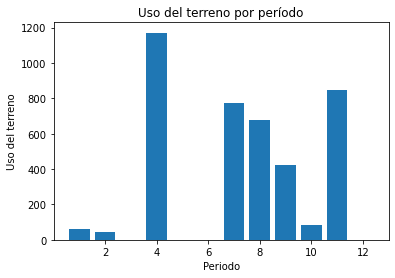

In [27]:
plt.bar(periodo, [ytemp[t].x for t in periodo])
 
## Legenda en el eje y
plt.ylabel('Uso del terreno')
 
## Legenda en el eje x
plt.xlabel('Periodo')
 
## Título de Gráfica
plt.title('Uso del terreno por período')
 
## Mostramos Gráfica
plt.show()

In [29]:
for t in periodo:
    if ytemp[t].x >0:
        print("Se deben contratar",int( ytemp[t].x),"horas con trabajadores temporales en el período",t)

Se deben contratar 60 horas con trabajadores temporales en el período 1
Se deben contratar 46 horas con trabajadores temporales en el período 2
Se deben contratar 1171 horas con trabajadores temporales en el período 4
Se deben contratar 771 horas con trabajadores temporales en el período 7
Se deben contratar 680 horas con trabajadores temporales en el período 8
Se deben contratar 425 horas con trabajadores temporales en el período 9
Se deben contratar 83 horas con trabajadores temporales en el período 10
Se deben contratar 845 horas con trabajadores temporales en el período 11


# References
Bisschop, J. J., & Roelofs, M. (1999). AIMMS. (AIMMS.) Haarlem: Paragon Decision Technology.